# Medical Cost Prediction

The primary goal of this code is to predict medical expenses (charges) for individuals based on a variety of input features using different regression models. 

#### **Dataset**

The dataset used for this analysis is Insurance dataset. The dataset contains 1338 observations and 7 variables. The variables are as follows:


| Variable | Description |
| --- | --- |
| age | age of primary beneficiary |
|bmi | body mass index |
|children | number of children covered by health insurance |
|smoker | smoking |
|region | the beneficiary's residential area in the US |
|charges | individual medical costs billed by health insurance |

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# File paths
zip_file_path = 'Medical Cost Personal.zip'  # Update with the correct path
extracted_folder = 'Medical_Cost_Data/'  # Folder to extract the files

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Path to the CSV file
csv_file_path = extracted_folder + 'insurance.csv'
df = pd.read_csv(csv_file_path)

# Display first few rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Preprocessing

In [3]:
#number of rows and columns
df.shape

(1338, 7)

In [4]:
#checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#checking discriptive statistics
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Key Findings

- **Age**: Older individuals might tend to have higher medical expenses, but the spread is quite large, so age alone won't be a strong predictor.
- **BMI**: Since most individuals have a BMI in the overweight/obese range, BMI can likely serve as a significant predictor of medical expenses, especially for higher charges.
- **Children**: The number of children doesn’t vary much, so it may not have a strong relationship with medical expenses unless there’s a factor like child-related health conditions or family coverage in healthcare plans.
- **Charges**: The range of medical expenses is wide, suggesting that a variety of factors (age, BMI, smoking, etc.) are influencing the outcome. Higher BMI and smoking likely correlate with higher medical expenses.

In [6]:
# Convert categorical variables to numerical
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['region'] = df['region'].map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})

# Checking balance of categorical variables (important for modeling)
print(f"Smoker balance: \n{df.smoker.value_counts()}")
print(f"Sex balance: \n{df.sex.value_counts()}")
print(f"Region balance: \n{df.region.value_counts()}")

Smoker balance: 
smoker
0    1064
1     274
Name: count, dtype: int64
Sex balance: 
sex
1    676
0    662
Name: count, dtype: int64
Region balance: 
region
1    364
0    325
2    325
3    324
Name: count, dtype: int64


In [7]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,2,21984.47061
4,32,1,28.880,0,0,2,3866.85520
5,31,0,25.740,0,0,1,3756.62160
6,46,0,33.440,1,0,1,8240.58960
7,37,0,27.740,3,0,2,7281.50560
8,37,1,29.830,2,0,3,6406.41070
9,60,0,25.840,0,0,2,28923.13692


## Exploratory Data Analysis

Visualization of the data is a good way to understand the data. In this section, I will plot the distribution of each variable to get an overview about their counts and distributions.

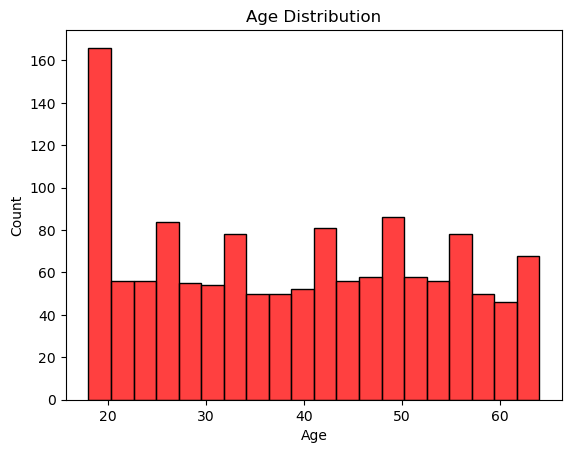

In [8]:
# age distribution
sns.histplot(df.age,bins=20, kde=False,color='red')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Gender Distribution')

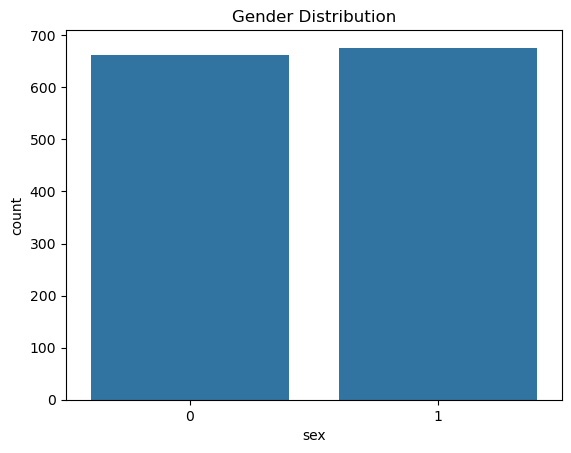

In [9]:
# gender plot
sns.countplot(x = 'sex', data = df)
plt.title('Gender Distribution')

It is clear that number of males and females are almost equal in the dataset.

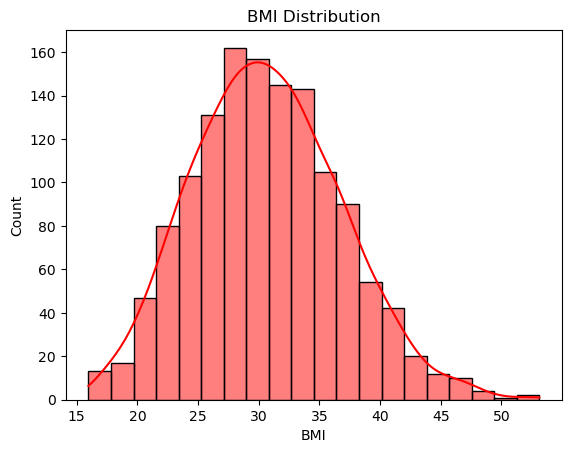

In [10]:
# bmi distribution
sns.histplot(df.bmi,bins=20, kde=True,color='red')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

The majority of the patients have BMI between 25 and 40 which is considered as overweight and could be a major factor in increasing the medical cost.

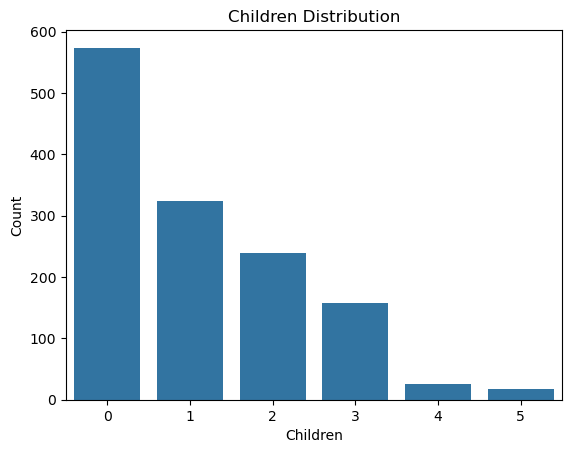

In [11]:
# child count distribution
sns.countplot(x = 'children', data = df)
plt.title('Children Distribution')
plt.xlabel('Children')
plt.ylabel('Count')
plt.show()

The graph clearly shows that most of the patients have no children and very few patients have more than 3 children.

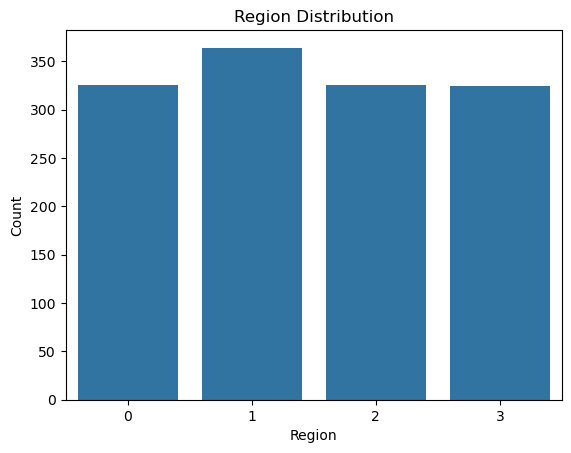

In [12]:
# regionwise plot
sns.countplot(x = 'region', data = df)
plt.title('Region Distribution')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

The count of patient from northwest is slighltly higher than the other regions, but the number of patients from other regions are almost equal.

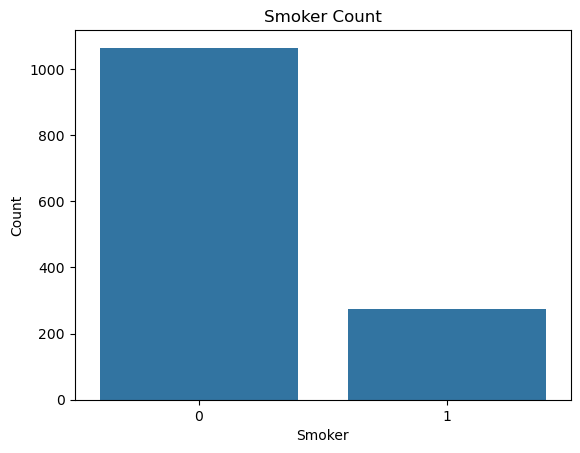

In [13]:
# count of smokers
sns.countplot(x = 'smoker', data = df)
plt.title('Smoker Count')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.show()

There are few smokers in the dataset. Nearly 80% of the patients are non-smokers.

Smoker count by children count.

<Axes: xlabel='smoker', ylabel='count'>

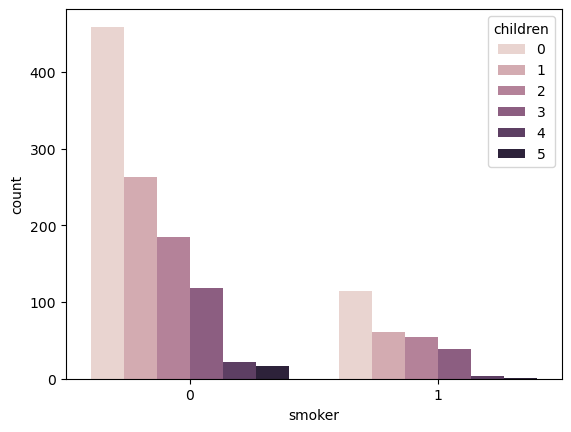

In [14]:
sns.countplot(x = df.smoker, hue = df.children)

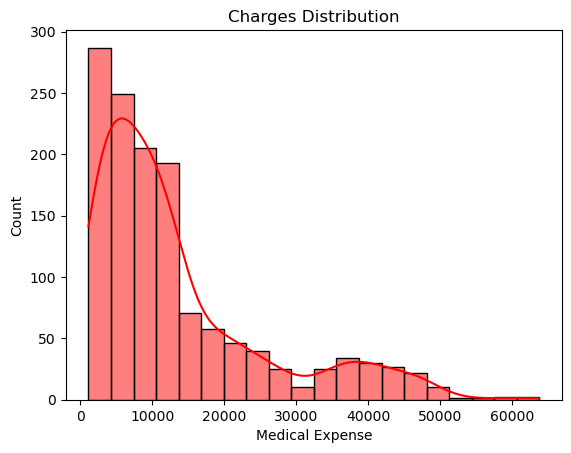

In [15]:
# charges distribution
sns.histplot(df.charges,bins=20, kde=True,color='red')
plt.title('Charges Distribution')
plt.xlabel('Medical Expense')
plt.ylabel('Count')
plt.show()

Most of the medical expenses are below 20000, with negligible number of patients having medical expenses above 50000.

From all the above plots, we have a clear understanding about the count of patients under each category of the variables. Now I will look into the coorelation between the variables.

## Correlation

In [16]:
# coorelation matrix
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,-0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,-0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,-0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,-0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.002181,0.787251
region,-0.002127,-0.004588,-0.157566,-0.016569,0.002181,1.000000,0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,0.006208,1.000000


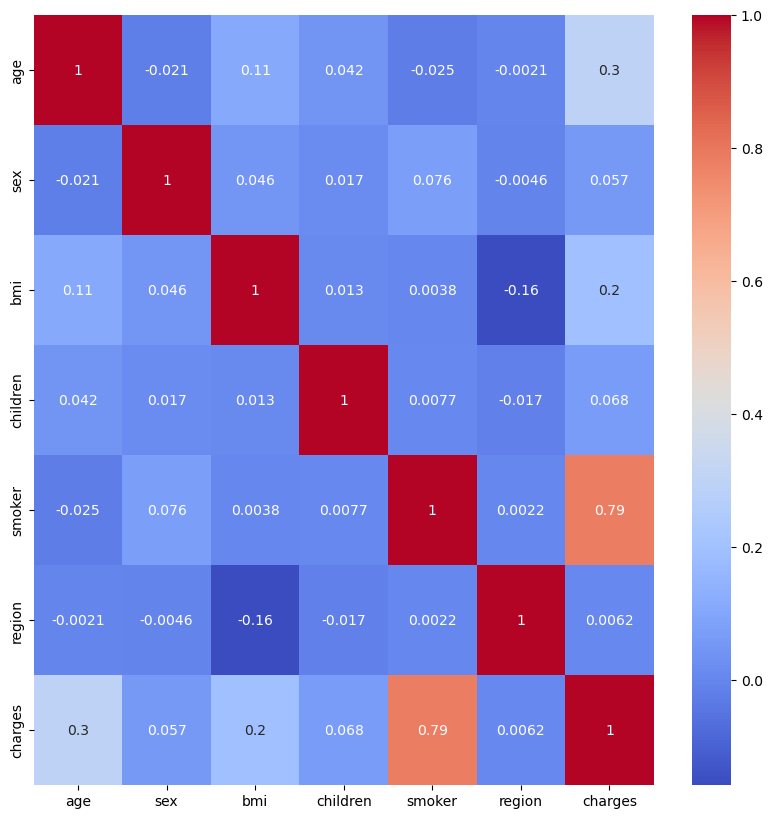

In [17]:
# plotting the coorelation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.show()

### Key Findings

- Smoker and charges have the strongest correlation (0.787), confirming that smoking status is a major predictor of medical expenses in this dataset.
- Age has a moderate positive correlation (0.299) with charges, suggesting that older individuals tend to have higher medical expenses.
- BMI has a weak positive correlation (0.198) with charges, implying that higher BMI is associated with higher medical costs, but it’s not the dominant factor.
- Sex, children, and region have weak correlations with medical charges, indicating they are less influential factors in predicting medical expenses in this dataset.

The variable smoker shows a significant coorelation with the medical expenses. Now I will explore more into patients' smoking habits and their relationa with other factors.

#### Plotting the smoker count with patient's gender

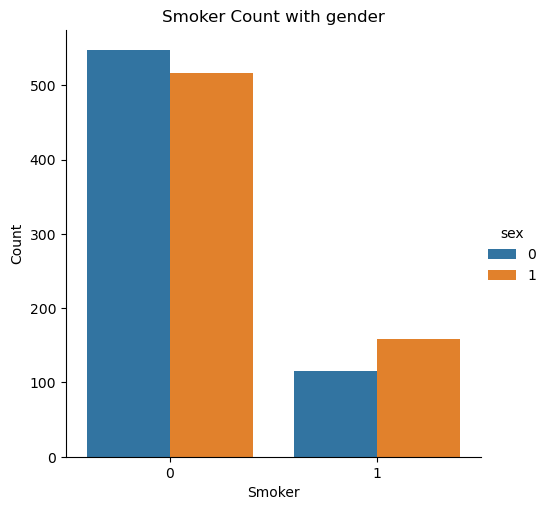

In [18]:
sns.catplot(x="smoker", kind="count",hue = 'sex', data=df)
plt.title('Smoker Count with gender')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.show()

We can notice more male smokers than female smokers. So, I will assume that medical treatment expense for males would be more than females, given the impact of smoking on the medical expenses.

<Axes: xlabel='sex', ylabel='charges'>

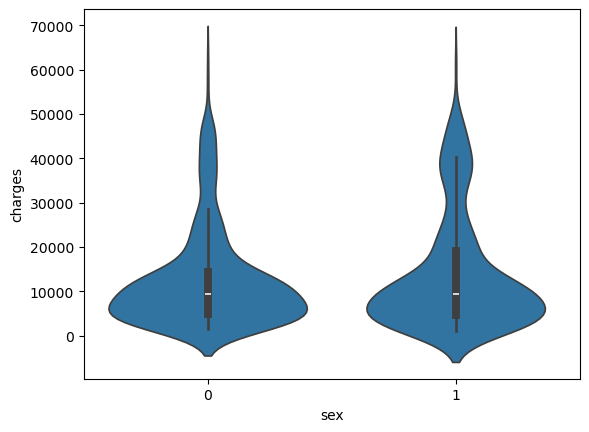

In [19]:
sns.violinplot(x = 'sex', y = 'charges', data = df)

<Axes: title={'center': 'Box plot for charges of women'}, xlabel='charges', ylabel='smoker'>

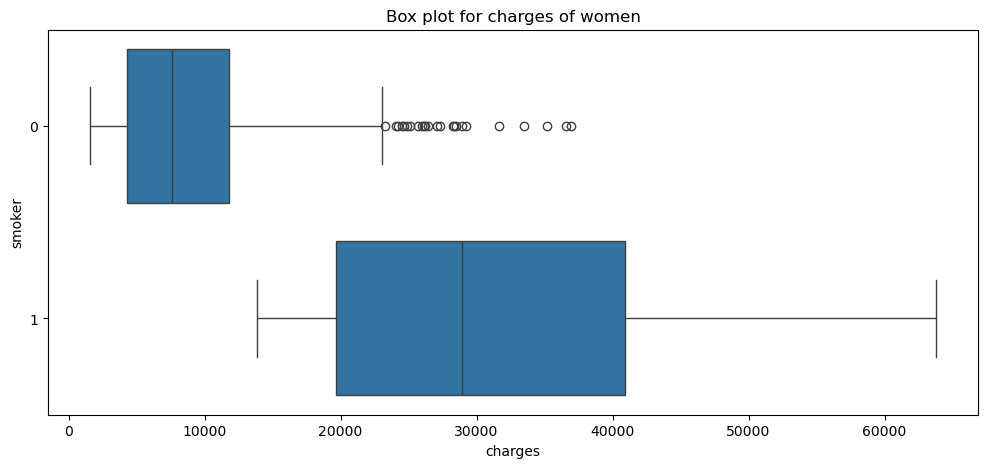

In [20]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  df[(df.sex == 0)] , orient="h")

<Axes: title={'center': 'Box plot for charges of men'}, xlabel='charges', ylabel='smoker'>

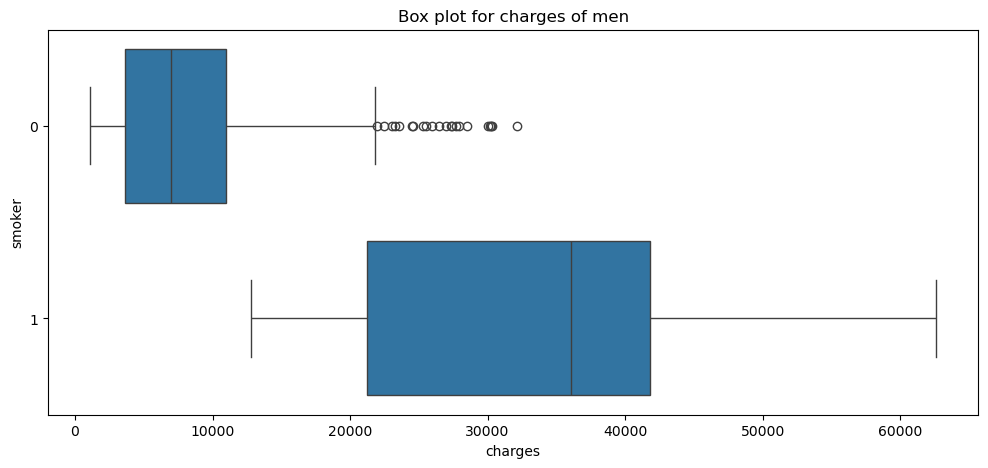

In [21]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  df[(df.sex == 1)] , orient="h")

The assumption is true, that the medical expense of males is greater than that of females. In addituion to that medical expense of smokers is greater than that of non-smokers.

#### Smokers and age distribution

C:\Users\milto\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


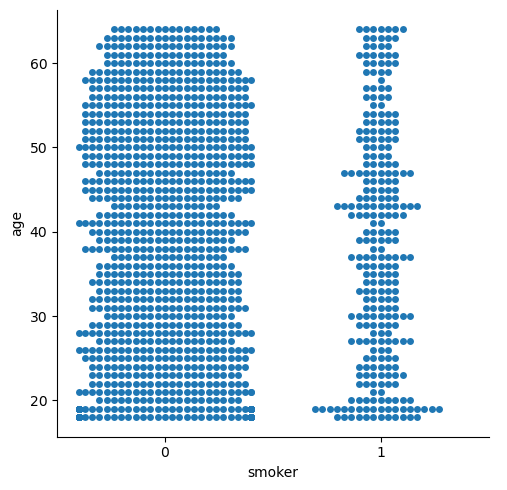

In [22]:
# smokers and age distribution
sns.catplot(x="smoker", y="age", kind="swarm", data=df)

From the graph, we can see that there significant number of smokers of age 19. Now I will study the medical expense of smokers of age 19.

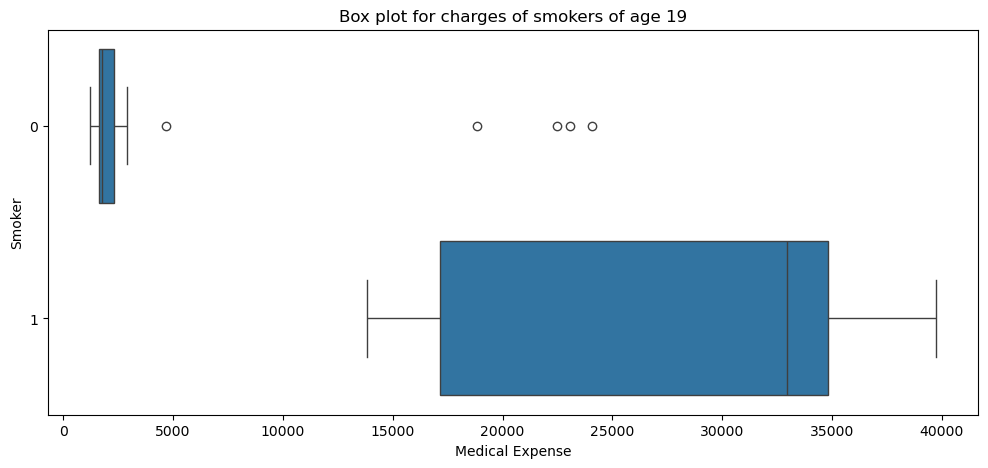

In [23]:
# smokers of age 19
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of smokers of age 19")
sns.boxplot(y="smoker", x="charges", data =  df[(df.age == 19)] , orient="h")
plt.xlabel('Medical Expense')
plt.ylabel('Smoker')
plt.show()

Surprisingly the medical expense of smokers of age 19 is very high in comparison to non smokers. In non smokers we can see some outliners, which may be due to illness or accidents.

It is clear that the medical expense of smokers is higher than that of non-smokers. Now I will plot the charges distribution with repect to patients age of smokers and non-smokers.

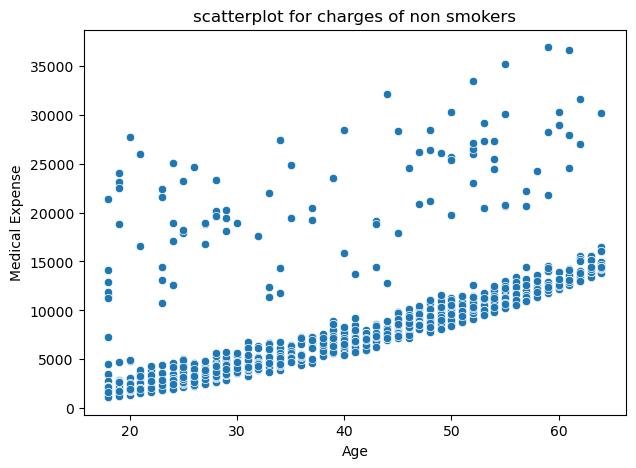

In [24]:
# non smokers charge distribution
plt.figure(figsize=(7,5))
plt.title("scatterplot for charges of non smokers")
sns.scatterplot(x="age", y="charges", data =  df[(df.smoker == 0)])
plt.xlabel('Age')
plt.ylabel('Medical Expense')
plt.show()

Majority of the points shows that medical expense increases with age which may be due to the fact that older people are more prone to illness. But there are some outliners which shows that there are other illness or accidents which may increase the medical expense.

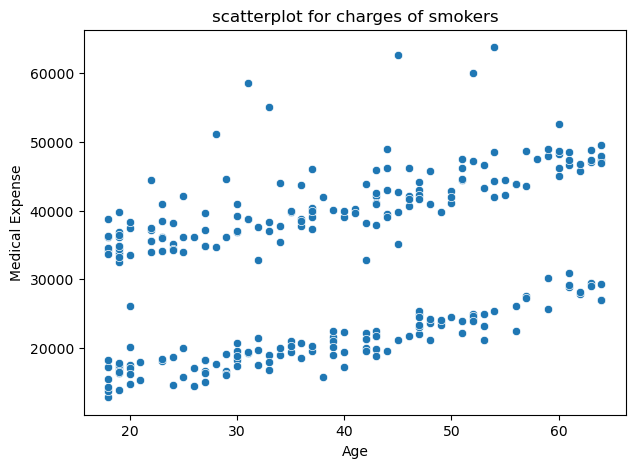

In [25]:
# smokers charge distribution
plt.figure(figsize=(7,5))
plt.title("scatterplot for charges of smokers")
sns.scatterplot(x="age", y="charges", data =  df[(df.smoker == 1)])
plt.xlabel('Age')
plt.ylabel('Medical Expense')
plt.show()

Here we see pecularity in the graph. In the graph there are two segments, one with high medical expense which may be due to smoking related illness and the other with low medical expense which may be due age related illness.

Now, in order to get a more clear picture, I will combine these two graphs.

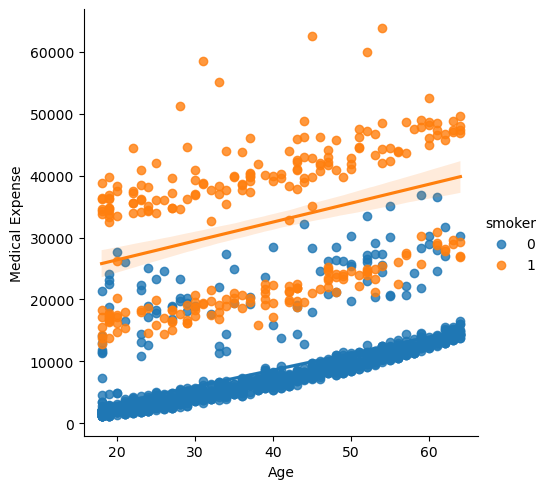

In [26]:
# age charges distribution

sns.lmplot(x="age", y="charges", data =  df, hue = 'smoker')
plt.xlabel('Age')
plt.ylabel('Medical Expense')
plt.show()

Now, we clearly understand the variation in charges with respect to age and smoking habits. The medical expense of smokers is higher than that of non-smokers.
In non-smokers, the cost of treatment increases with age which is obvious. But in smokers, the cost of treatment is high even for younger patients, which means the smoking patients are spending upon their smoking related illness as well as age related illness.

#### Charges distribution for patients with BMI greater than 30 i.e. obese patients

C:\Users\milto\AppData\Local\Temp\ipykernel_2932\1195281650.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[(df.bmi >= 30)]['charges'])


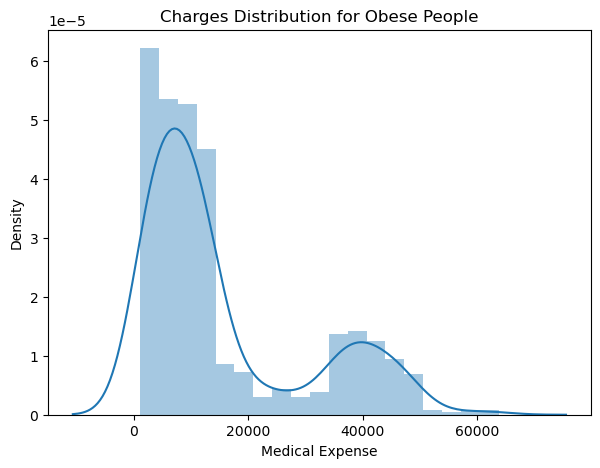

In [27]:
# bmi charges distribution for obese people
plt.figure(figsize=(7,5))
sns.distplot(df[(df.bmi >= 30)]['charges'])
plt.title('Charges Distribution for Obese People')
plt.xlabel('Medical Expense')
plt.show()

#### Charges distribution for patients with BMI less than 30 i.e. healthy patients

C:\Users\milto\AppData\Local\Temp\ipykernel_2932\887406048.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[(df.bmi < 30)]['charges'])


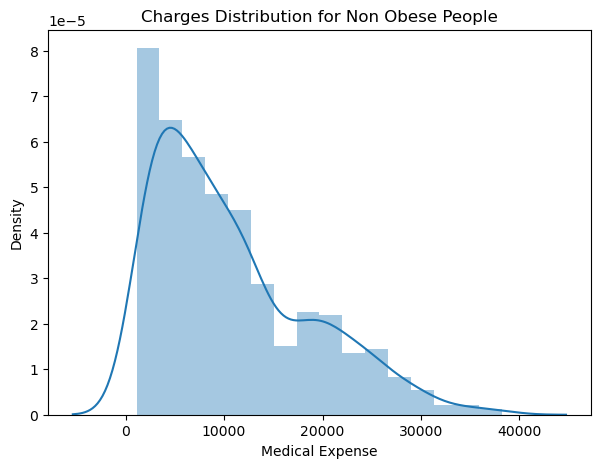

In [28]:
plt.figure(figsize=(7,5))
sns.distplot(df[(df.bmi < 30)]['charges'])
plt.title('Charges Distribution for Non Obese People')
plt.xlabel('Medical Expense')
plt.show()

Therefore, patients with BMI less than 30 are spending less on medical treatment than those with BMI greater than 30.

##### Through the EDA, we have a clear understanding about the data and the coorelation between the variables. Now, I will build a model to predict the medical expense of patients.

A new feature is created by multiplying age and bmi (age_bmi_interaction). This is an example of feature engineering where interactions between variables are considered to improve predictive modeling.

In [29]:
# Feature Engineering - Create interactions between variables (e.g., age*bmi)
df['age_bmi_interaction'] = df['age'] * df['bmi']

## Train Test Split

In [30]:
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model Building

In [31]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Polynomial Regression
poly_reg = PolynomialFeatures(degree=2)
X_train_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.transform(X_test)
plr = LinearRegression()
plr.fit(X_train_poly, y_train)
y_pred_poly = plr.predict(X_test_poly)

# Decision Tree Regressor
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## Evaluation


Linear Regression - Evaluation Metrics:
MAE: 3937.551087211801
MSE: 31929251.859786786
RMSE: 5650.597478124485
R²: 0.7993511002337031


C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true, hist=False, color='r', label='Actual Value')
C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y

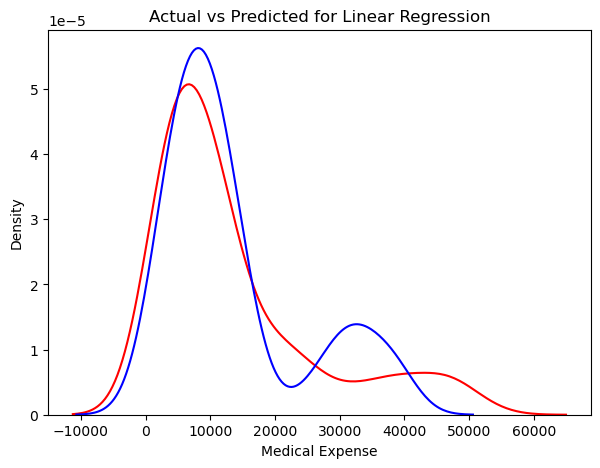


Polynomial Regression - Evaluation Metrics:
MAE: 2920.8841464553325
MSE: 19031533.65820541
RMSE: 4362.514602635206
R²: 0.8804025754767665


C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true, hist=False, color='r', label='Actual Value')
C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y

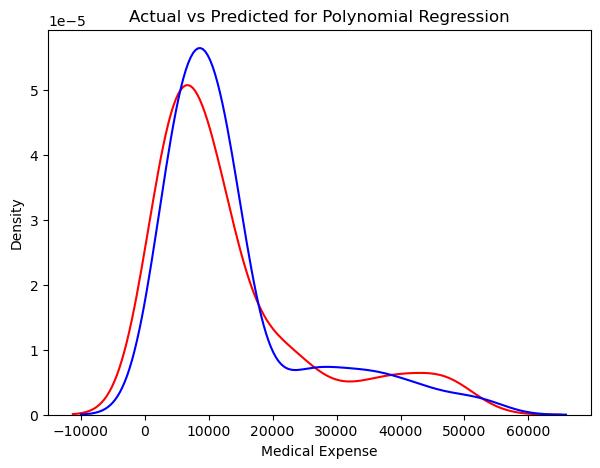


Decision Tree Regressor - Evaluation Metrics:
MAE: 3758.560859175373
MSE: 60085320.862758525
RMSE: 7751.472173900808
R²: 0.6224135292564938


C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true, hist=False, color='r', label='Actual Value')
C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y

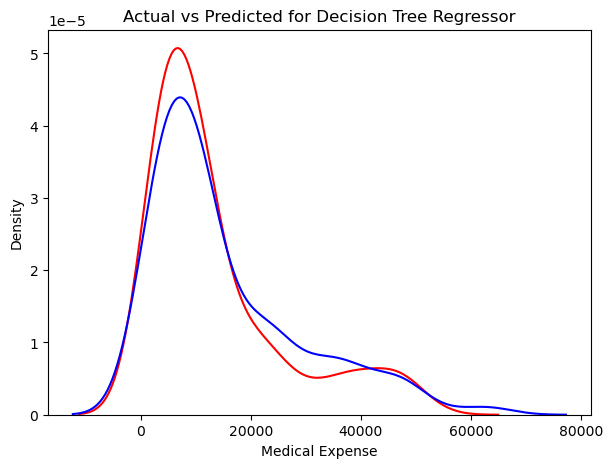


Random Forest Regressor - Evaluation Metrics:
MAE: 2689.110086740733
MSE: 20205311.345642067
RMSE: 4495.0318514602395
R²: 0.8730263549944126


C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true, hist=False, color='r', label='Actual Value')
C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y

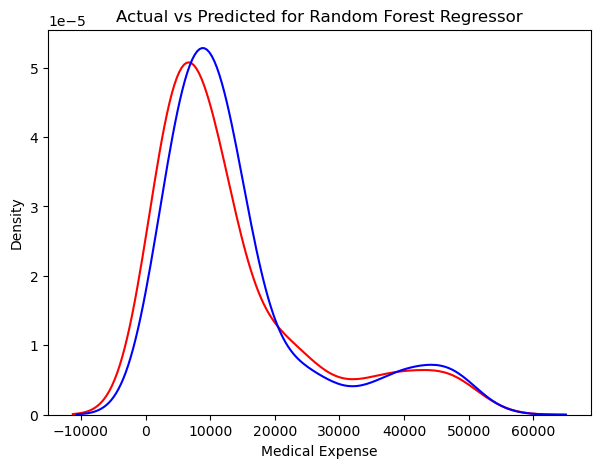

In [32]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R²: {r2_score(y_true, y_pred)}")
    plt.figure(figsize=(7, 5))
    sns.distplot(y_true, hist=False, color='r', label='Actual Value')
    sns.distplot(y_pred, hist=False, color='b', label='Predicted Value')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.xlabel('Medical Expense')
    plt.show()

# Evaluate all models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_poly, "Polynomial Regression")
evaluate_model(y_test, y_pred_dtree, "Decision Tree Regressor")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")

### Key Findings

- **Best Model (Overall)**: Polynomial Regression has the best performance in terms of the lowest MAE, MSE, RMSE, and highest R².
- **Runner-up**: Random Forest Regressor is also a strong contender, with low MAE and competitive other metrics. It is very close to polynomial regression in terms of R².
- **Underperformer**: Decision Tree Regressor has the worst performance, with the highest MAE, MSE, and RMSE, and the lowest R².

## Hyperparameter tuning

The Random Forest model undergoes hyperparameter tuning using GridSearchCV, where a grid of hyperparameter values is tested (e.g., n_estimators, max_depth, min_samples_split).

In [33]:
# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


The **best** combination of parameters is selected using cross-validation, and the performance of this tuned Random Forest model is evaluated on the test set.


Best Random Forest Regressor (Tuned) - Evaluation Metrics:
MAE: 2617.798448707875
MSE: 18773285.92461471
RMSE: 4332.815011584814
R²: 0.8820254485662977


C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true, hist=False, color='r', label='Actual Value')
C:\Users\milto\AppData\Local\Temp\ipykernel_2932\3708952570.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y

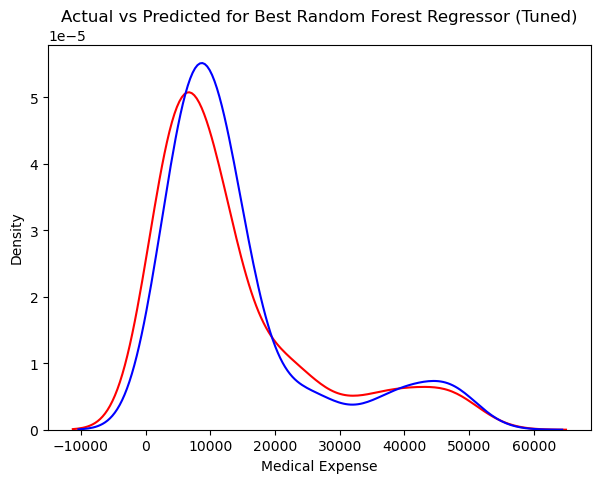

In [34]:
# Evaluate best Random Forest model
y_pred_best_rf = best_rf.predict(X_test)
evaluate_model(y_test, y_pred_best_rf, "Best Random Forest Regressor (Tuned)")

### Key Findings

- **Cross-Validation**: The output suggests that you ran cross-validation to tune the hyperparameters of the Random Forest Regressor, testing 27 different combinations of hyperparameters over 5-fold splits.

- The tuning process improved the model's performance across the board. The reduction in MAE, MSE, and RMSE signifies better generalization, and the higher R² confirms that the model is now better at explaining the variance in medical charges.

## Residual Analysis

The code performs residual analysis by calculating the **residuals** (differences between actual and predicted values) for each model.

In [35]:
# Residual analysis (for all models)
def residual_analysis(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.title(f'Residuals for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

The residuals are plotted against the predicted values to help visualize how well each model is performing. Ideally, residuals should be randomly scattered around zero, indicating no pattern or bias.

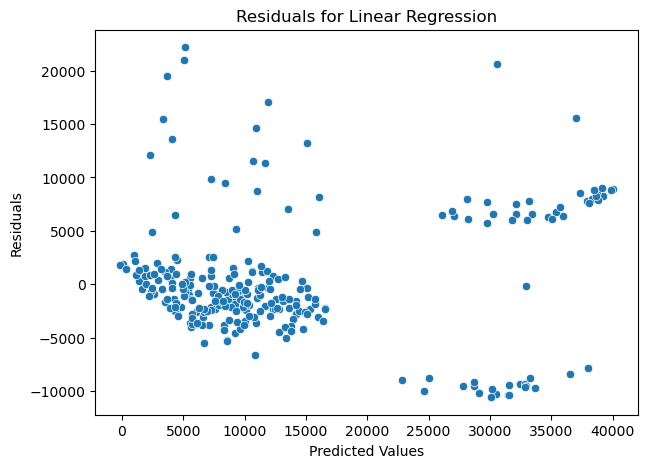

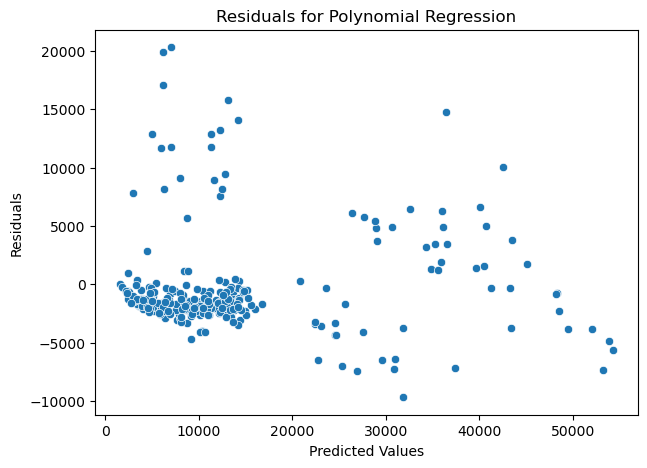

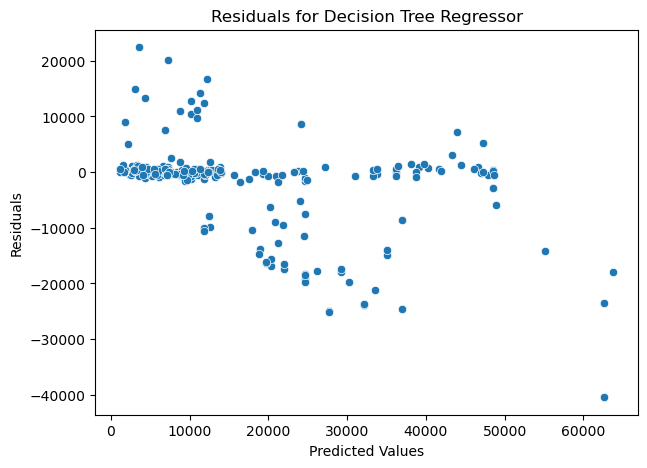

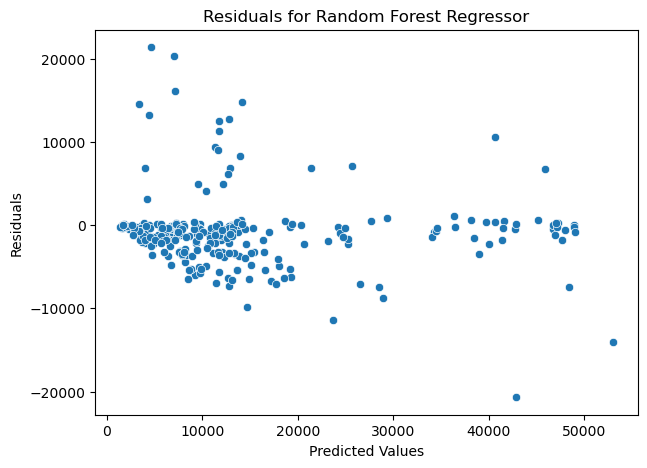

In [36]:
# Residual analysis for all models
residual_analysis(y_test, y_pred_lr, "Linear Regression")
residual_analysis(y_test, y_pred_poly, "Polynomial Regression")
residual_analysis(y_test, y_pred_dtree, "Decision Tree Regressor")
residual_analysis(y_test, y_pred_rf, "Random Forest Regressor")

## Conclusion
The project demonstrates that smoking status is a major predictor of medical expenses, with BMI and age also playing significant roles. The models evaluated showed that Polynomial Regression outperforms the others in terms of prediction accuracy, while Random Forest provides a strong alternative, especially when hyperparameters are tuned. This analysis offers valuable insights into the factors influencing medical costs and highlights the potential for using machine learning models to predict medical expenses based on individual characteristics.